In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 # for image resizing
import numpy as np
import pandas as pd

%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
print(tf.__version__)

Using TensorFlow backend.


1.10.0


In [129]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import ModelCheckpoint, Callback

In [61]:
train_dir = './dataset/train'
val_dir = './dataset/val'

 
nTrain = 1728
nVal = 480

In [107]:
datagen = ImageDataGenerator(width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1,rescale=1./255)
batch_size = 16
 
train_features = np.zeros(shape=(nTrain, 128, 128, 3))
train_labels = np.zeros(shape=(nTrain,7))
 
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

val_features = np.zeros(shape=(nVal, 128, 128, 3))
val_labels = np.zeros(shape=(nVal,7))
 
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 1728 images belonging to 7 classes.
Found 480 images belonging to 7 classes.


In [108]:
i = 0
for inputs_batch, labels_batch in train_generator:
    train_features[i * batch_size : (i + 1) * batch_size] = inputs_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTrain:
        break

C:\Users\debji\Anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 70 bytes but only got 25. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag))


In [109]:
i=0
for inputs_batch, labels_batch in val_generator:
    val_features[i * batch_size : (i + 1) * batch_size] = inputs_batch
    val_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nVal:
        break

In [65]:
train_features.shape

(1728, 128, 128, 3)

In [78]:
model_simple = models.Sequential()
model_simple.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))
model_simple.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model_simple.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_simple.add(layers.Dropout(0.25))

model_simple.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model_simple.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model_simple.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_simple.add(layers.Dropout(0.25))

model_simple.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
model_simple.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
model_simple.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_simple.add(layers.Dropout(0.25))

model_simple.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))
model_simple.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))
model_simple.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_simple.add(layers.Dropout(0.25))

model_simple.add(layers.Flatten())
model_simple.add(layers.Dense(512, activation='relu'))
model_simple.add(layers.Dropout(0.3))
model_simple.add(layers.Dense(256, activation='relu'))
model_simple.add(layers.Dropout(0.3))
model_simple.add(layers.Dense(128, activation='relu'))
model_simple.add(layers.Dropout(0.3))

model_simple.add(layers.Dense(7, activation='softmax'))

# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = optimizers.Adam(lr=0.0001, decay=1e-5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_weights_only=True)
model_simple.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'],optimizer=opt)

model_simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 32, 32, 64)        0         
__________

In [79]:
history = model_simple.fit(train_features,
                    train_labels,
                    epochs=50,
                    batch_size=batch_size,
                    validation_data=(val_features,val_labels),callbacks=[chkpt])

Train on 1728 samples, validate on 480 samples
Epoch 1/50
1728/1728 [==============================] - 105s 61ms/step - loss: 1.9434 - categorical_accuracy: 0.1557 - val_loss: 1.9445 - val_categorical_accuracy: 0.1292
Epoch 2/50
1728/1728 [==============================] - 10s 6ms/step - loss: 1.8885 - categorical_accuracy: 0.2043 - val_loss: 1.8127 - val_categorical_accuracy: 0.2521
Epoch 3/50
1728/1728 [==============================] - 9s 5ms/step - loss: 1.7050 - categorical_accuracy: 0.3119 - val_loss: 1.6190 - val_categorical_accuracy: 0.3396
Epoch 4/50
1728/1728 [==============================] - 10s 6ms/step - loss: 1.6468 - categorical_accuracy: 0.3235 - val_loss: 1.6350 - val_categorical_accuracy: 0.3646
Epoch 5/50
1728/1728 [==============================] - 10s 6ms/step - loss: 1.5879 - categorical_accuracy: 0.3553 - val_loss: 1.5978 - val_categorical_accuracy: 0.3583
Epoch 6/50
1728/1728 [==============================] - 10s 6ms/step - loss: 1.5203 - categorical_accuracy:

Epoch 49/50
1728/1728 [==============================] - 9s 5ms/step - loss: 0.0950 - categorical_accuracy: 0.9734 - val_loss: 2.3742 - val_categorical_accuracy: 0.5958
Epoch 50/50
1728/1728 [==============================] - 9s 5ms/step - loss: 0.0603 - categorical_accuracy: 0.9809 - val_loss: 2.5059 - val_categorical_accuracy: 0.5896


In [80]:
model_simple.load_weights("best_model_todate")

In [110]:
fnames = val_generator.filenames
 
ground_truth = val_generator.classes
 
label2index = val_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
predictions = model_simple.predict_classes(val_features)
prob = model_simple.predict(val_features)
 
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

No of errors = 189/480


In [111]:
fnames = train_generator.filenames
 
ground_truth = train_generator.classes
 
label2index = train_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
predictions = model_simple.predict_classes(train_features)
prob = model_simple.predict(train_features)
 
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nTrain))

No of errors = 342/1728


In [83]:
from keras.applications import VGG16
 
vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [112]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 16
 
train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,7))
 
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

val_features = np.zeros(shape=(nVal, 7, 7, 512))
val_labels = np.zeros(shape=(nVal,7))
 
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 1728 images belonging to 7 classes.
Found 480 images belonging to 7 classes.


In [113]:
i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTrain:
        break
         
train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))

C:\Users\debji\Anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 70 bytes but only got 25. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag))


In [114]:
i=0
for inputs_batch, labels_batch in val_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    val_features[i * batch_size : (i + 1) * batch_size] = features_batch
    val_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nVal:
        break
         
val_features = np.reshape(val_features, (nVal, 7 * 7 * 512))

In [115]:
model_transfer = models.Sequential()
model_transfer.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model_transfer.add(layers.Dropout(0.3))
model_transfer.add(layers.Dense(128, activation='relu'))
model_transfer.add(layers.Dropout(0.3))
model_transfer.add(layers.Dense(7, activation='softmax'))
                   
opt = optimizers.Adam(lr=0.0001, decay=1e-5)
chkpt = ModelCheckpoint(filepath='best_transfer_model_todate', save_weights_only=True)
model_transfer.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'],optimizer=opt)

model_transfer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_57 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_58 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 7)                 903       
Total params: 6,456,583
Trainable params: 6,456,583
Non-trainable params: 0
_________________________________________________________________


In [119]:
history = model_transfer.fit(train_features,
                    train_labels,
                    epochs=50,
                    batch_size=batch_size,
                    validation_data=(val_features,val_labels),callbacks=[chkpt])

Train on 1728 samples, validate on 480 samples
Epoch 1/50
1728/1728 [==============================] - 2s 1ms/step - loss: 0.0108 - categorical_accuracy: 0.9971 - val_loss: 1.2222 - val_categorical_accuracy: 0.7521
Epoch 2/50
1728/1728 [==============================] - 2s 1ms/step - loss: 0.0087 - categorical_accuracy: 0.9977 - val_loss: 1.2346 - val_categorical_accuracy: 0.7667
Epoch 3/50
1728/1728 [==============================] - 2s 1ms/step - loss: 0.0122 - categorical_accuracy: 0.9977 - val_loss: 1.1798 - val_categorical_accuracy: 0.7604
Epoch 4/50
1728/1728 [==============================] - 2s 1ms/step - loss: 0.0117 - categorical_accuracy: 0.9965 - val_loss: 1.2157 - val_categorical_accuracy: 0.7667
Epoch 5/50
1728/1728 [==============================] - 2s 1ms/step - loss: 0.0051 - categorical_accuracy: 0.9994 - val_loss: 1.3820 - val_categorical_accuracy: 0.7688
Epoch 6/50
1728/1728 [==============================] - 2s 1ms/step - loss: 0.0098 - categorical_accuracy: 0.9977

1728/1728 [==============================] - 2s 1ms/step - loss: 0.0133 - categorical_accuracy: 0.9959 - val_loss: 1.4709 - val_categorical_accuracy: 0.7458
Epoch 50/50
1728/1728 [==============================] - 2s 1ms/step - loss: 0.0030 - categorical_accuracy: 0.9994 - val_loss: 1.4513 - val_categorical_accuracy: 0.7667


In [120]:
model_transfer.load_weights("best_transfer_model_todate")

In [121]:
fnames = train_generator.filenames
 
ground_truth = train_generator.classes
 
label2index = train_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
predictions = model_transfer.predict_classes(train_features)
prob = model_transfer.predict(train_features)
 
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nTrain))

No of errors = 2/1728


In [122]:
fnames = val_generator.filenames
 
ground_truth = val_generator.classes
 
label2index = val_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
predictions = model_transfer.predict_classes(val_features)
prob = model_transfer.predict(val_features)
 
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

No of errors = 112/480


Original label:0\148. bird39s-eye-view-of-city-buildings-during-sunset.jpg, Prediction :2, confidence : 0.836


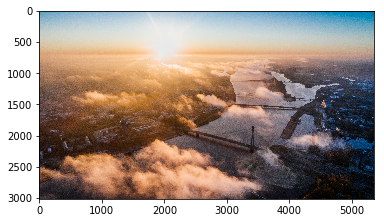

Original label:0\159. .jpg, Prediction :2, confidence : 0.990


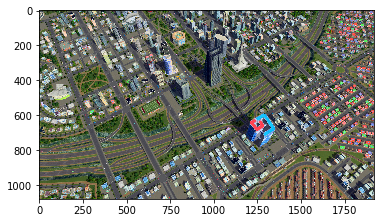

Original label:0\180. s-l300.jpg, Prediction :2, confidence : 0.574


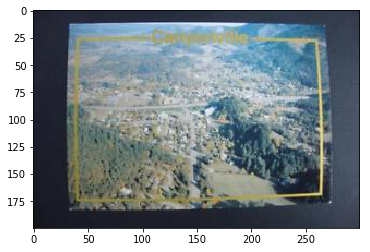

Original label:0\196. cities-skylines-construction.jpg, Prediction :4, confidence : 0.996


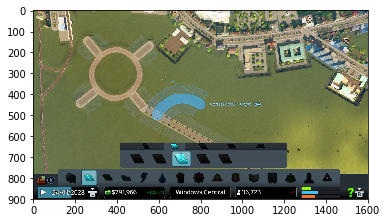

Original label:1\111. mypop-beach-ocean-theme-shower-curtain-wavy-ocean-surface-scenery-polyester-fabric-mildew-resistant-and-waterproof-bath-curtains-66-by-72-inches-blue-turquoise-sand.jpg, Prediction :0, confidence : 0.999


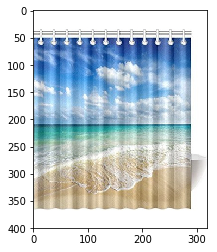

Original label:1\112. gettyimages-121102975-5a044b97beba33001a783721.jpg, Prediction :3, confidence : 0.825


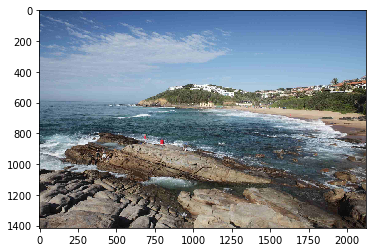

Original label:1\117. lindquist-beach.jpg, Prediction :3, confidence : 0.965


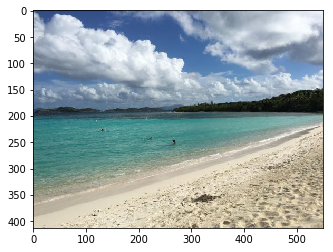

Original label:1\123. beach-rocks-ocean-waves-and-sand-scenery-picture-id673808378.jpg, Prediction :3, confidence : 0.986


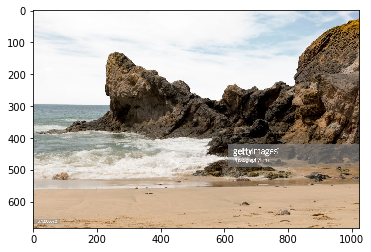

Original label:1\129. california-beaches-big-sur-1491512280.jpg, Prediction :6, confidence : 0.544


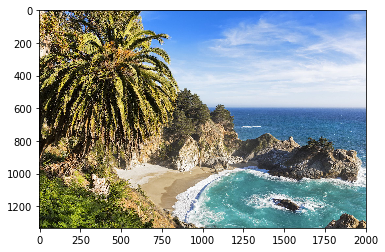

Original label:1\133. 857-94962.jpg, Prediction :5, confidence : 0.812


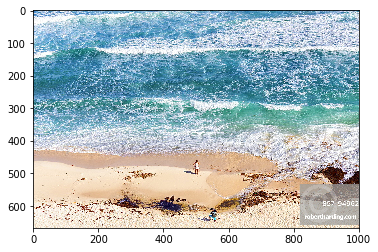

Original label:1\134. 63f6a4c4db81805e6e2d48d75826195a-700.jpg, Prediction :4, confidence : 0.916


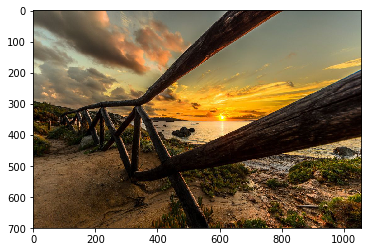

Original label:1\276. praia-da-marinha-beach-marinha-in-algarve-portugal-best-beaches-in-europe.jpg, Prediction :2, confidence : 0.971


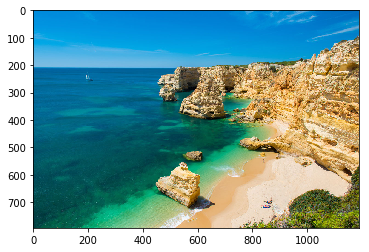

Original label:1\285. mypop-beach-ocean-theme-shower-curtain-wavy-ocean-surface-scenery-polyester-fabric-mildew-resistant-and-waterproof-bath-curtains-60-by-72-inches-extra-long-blue-turquoise-sand.jpg, Prediction :0, confidence : 0.995


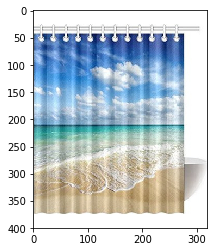

Original label:1\286. 33485618.jpg, Prediction :6, confidence : 0.646


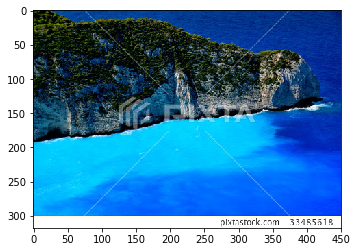

Original label:1\288. 1502454717_goa-beach-2.jpg, Prediction :3, confidence : 0.756


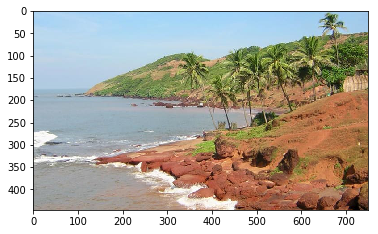

Original label:1\289. visionsofvictoria1082091-304.jpg, Prediction :6, confidence : 1.000


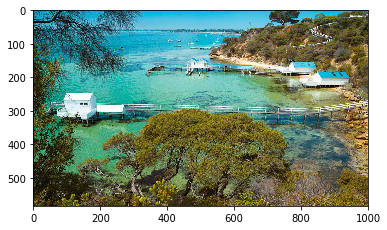

Original label:1\290. 30291809357_d74b517fa9_b.jpg, Prediction :3, confidence : 0.996


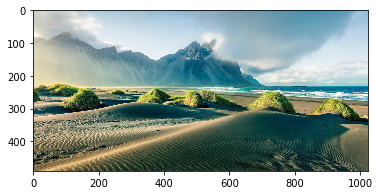

Original label:1\292. tropical-1164934__340.jpg, Prediction :5, confidence : 0.999


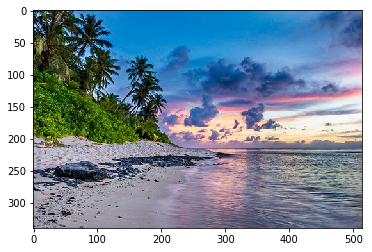

Original label:1\293. 500_f_205876318_gldwaie3jccttpniwkjlkyq3riuyvxb2.jpg, Prediction :3, confidence : 0.904


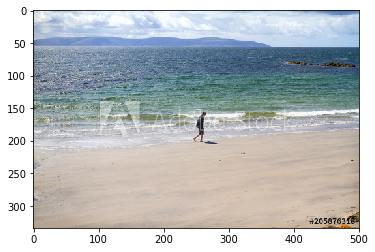

Original label:1\33. the-nautilus-maldives-beach-residence.jpg, Prediction :0, confidence : 1.000


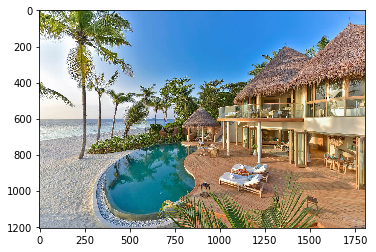

Original label:1\39. hideaway-maldives_hideaway_watervilla_1-1030x579.jpg, Prediction :4, confidence : 0.739


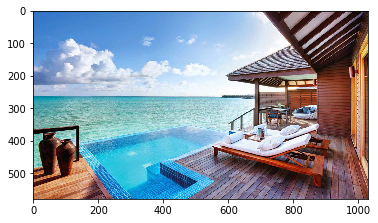

Original label:2\137. 77a9a12e51c44d30b044ac446056c0bf.jpg, Prediction :4, confidence : 0.995


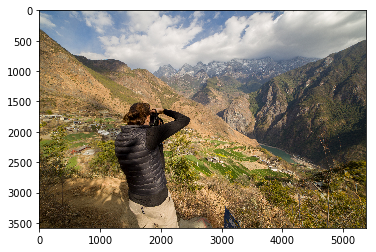

In [131]:
#Visualising erros, most are caused because yellowness leads to desert prediction
num_errors = int(len(errors)/5)
for i in range(num_errors):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
     
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
     
    original = load_img('{}/{}'.format(val_dir,fnames[errors[i]]))
    plt.imshow(original)
    plt.show()